In [2]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import kagglehub
import os
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

c:\Users\sasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download latest version
path = kagglehub.dataset_download("ritesaluja/bank-note-authentication-uci-data")

100%|██████████| 19.2k/19.2k [00:00<00:00, 131kB/s]

Extracting files...


In [5]:
print(os.listdir(path))

['BankNote_Authentication.csv']


In [6]:
df = pd.read_csv(path + "/BankNote_Authentication.csv")

In [7]:
print("Размер данных:", df.shape)
print("\nПервые строки:")
print(df.head())
print("\nОписание данных:")
print(df.describe())
print("\nРаспределение классов:")
print(df['class'].value_counts())

Размер данных: (1372, 5)

Первые строки:
   variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0

Описание данных:
          variance     skewness     curtosis      entropy        class
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000

Распределение

1. Проанализировать разные результаты для набора данных BanknoteAuthentification, в
чём разница базовых настроек алгоритма в разных инструментах?

In [8]:
df_copy = df.copy()
X = df_copy.drop('class', axis=1)
y = df_copy['class']
print(f"Размер X = {X.shape}")
print(f"Размер y = {y.shape}")

Размер X = (1372, 4)
Размер y = (1372,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(f"Обучающая выборка: {X_train.shape[0]} объектов")
print(f"Тестовая выборка: {X_test.shape[0]} объектов")

Обучающая выборка: 1097 объектов
Тестовая выборка: 275 объектов


In [11]:
kernels = ['linear', 'rbf', 'poly']

тестируем модель на разных ядрах

In [12]:
for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred)
    print(f"Ядро {kernel:6s}: accuracy = {accuracy:.4f}")

Ядро linear: accuracy = 0.9855
Ядро rbf   : accuracy = 1.0000
Ядро poly  : accuracy = 0.9745


у rbf 100%, надо понять, переобучение ли это. Проверим с помощью кросс-валидации (другие ядра тоже прогоним)

2. Найти наилучшие параметры для данных BanknoteAuthentification, используя технику
кросс-валидации

In [13]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
    }

In [14]:
grid = GridSearchCV(
    svm.SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

In [15]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'gamma': [1, 0.1, ...], 'kernel': ['rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold an

Все комбинации (отсортировано по accuracy):
    C  gamma  accuracy      std
  1.0  0.100  1.000000 0.000000
100.0  0.010  1.000000 0.000000
 10.0  0.010  1.000000 0.000000
 10.0  0.100  1.000000 0.000000
100.0  0.100  1.000000 0.000000
100.0  0.001  0.999087 0.001826
 10.0  1.000  0.998182 0.003636
  1.0  1.000  0.998182 0.003636
100.0  1.000  0.998182 0.003636
  1.0  0.010  0.995446 0.004979
  0.1  0.100  0.991802 0.005311
 10.0  0.001  0.988144 0.008457
  0.1  0.010  0.984504 0.004652
  1.0  0.001  0.979033 0.007410
  0.1  0.001  0.957156 0.012433
  0.1  1.000  0.754790 0.016607


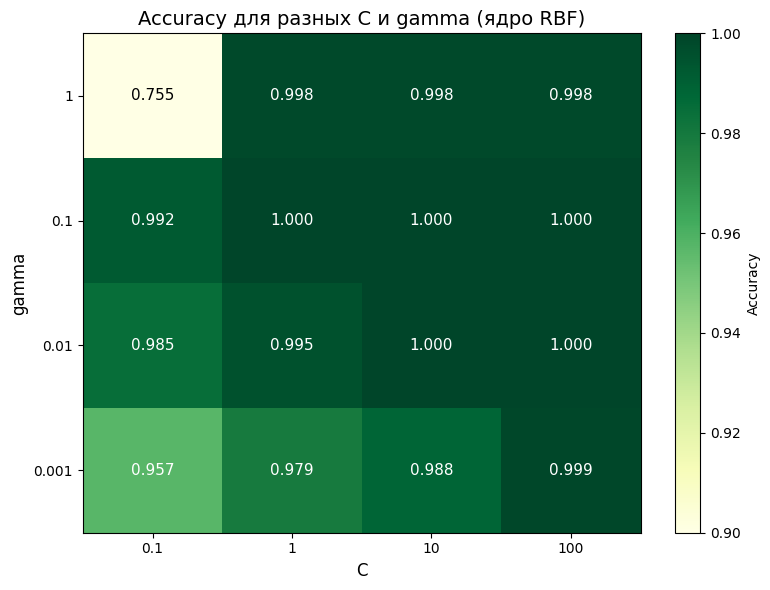


Лучшие параметры: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Лучшая accuracy: 1.0000


In [16]:
results = pd.DataFrame(grid.cv_results_)
results_clean = results[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']]
results_clean = results_clean.sort_values('mean_test_score', ascending=False)
results_clean.columns = ['C', 'gamma', 'accuracy', 'std']
print("Все комбинации (отсортировано по accuracy):")
print(results_clean.to_string(index=False))

C_values = [0.1, 1, 10, 100]
gamma_values = [1, 0.1, 0.01, 0.001]

accuracy_matrix = np.zeros((len(gamma_values), len(C_values)))

for i, gamma in enumerate(gamma_values):
    for j, C in enumerate(C_values):
        mask = (results['param_gamma'] == gamma) & (results['param_C'] == C)
        accuracy_matrix[i, j] = results[mask]['mean_test_score'].values[0]

plt.figure(figsize=(8, 6))
im = plt.imshow(accuracy_matrix, cmap='YlGn', aspect='auto', vmin=0.9, vmax=1.0)

plt.xticks(range(len(C_values)), C_values)
plt.yticks(range(len(gamma_values)), gamma_values)
plt.xlabel('C', fontsize=12)
plt.ylabel('gamma', fontsize=12)
plt.title('Accuracy для разных C и gamma (ядро RBF)', fontsize=14)

for i in range(len(gamma_values)):
    for j in range(len(C_values)):
        color = 'white' if accuracy_matrix[i, j] > 0.95 else 'black'
        plt.text(j, i, f'{accuracy_matrix[i, j]:.3f}', ha='center', va='center', fontsize=11, color=color)

plt.colorbar(im, label='Accuracy')
plt.tight_layout()
plt.show()

print(f"\nЛучшие параметры: {grid.best_params_}")
print(f"Лучшая accuracy: {grid.best_score_:.4f}")

3. Теперь для датасета AdultIncome

In [17]:
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

100%|██████████| 652k/652k [00:00<00:00, 740kB/s]

Extracting files...


In [18]:
print(os.listdir(path))

['adult.csv']


In [19]:
df_adult = pd.read_csv(path + "/adult.csv")

In [20]:
print("Размер данных:", df_adult.shape)
print("\nПервые строки:")
print(df_adult.head())
print("\nРаспределение классов:")
print(df_adult['income'].value_counts())

Размер данных: (48842, 15)

Первые строки:
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0

In [21]:
df_adult_clean = df_adult.dropna()
print(f"После удаления пропусков: {df_adult_clean.shape[0]} объектов")

X_adult = df_adult_clean.drop('income', axis=1)
y_adult = df_adult_clean['income']

X_adult_encoded = pd.get_dummies(X_adult)
print(f"Размер после кодирования: {X_adult_encoded.shape}")

y_adult_encoded = (y_adult == '>50K').astype(int)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_adult_encoded, y_adult_encoded, test_size=0.2, random_state=42
)

# Стандартизация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_a)
X_test_scaled = scaler.transform(X_test_a)

print(f"\nОбучающая выборка: {X_train_scaled.shape[0]} объектов")
print(f"Тестовая выборка: {X_test_scaled.shape[0]} объектов")

clf_base = svm.SVC(kernel='rbf')
clf_base.fit(X_train_scaled, y_train_a)
pred_base = clf_base.predict(X_test_scaled)
accuracy_base = metrics.accuracy_score(y_test_a, pred_base)
print(f"\nБазовая accuracy (параметры по умолчанию): {accuracy_base:.4f}")

После удаления пропусков: 48842 объектов


Размер после кодирования: (48842, 108)

Обучающая выборка: 39073 объектов
Тестовая выборка: 9769 объектов

Базовая accuracy (параметры по умолчанию): 0.8540


In [22]:
# Берём часть данных для ускорения (10000 объектов)
X_sample = X_train_scaled[:10000]
y_sample = y_train_a[:10000]

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid_adult = GridSearchCV(
    svm.SVC(),
    param_grid,
    cv=3,  # 3-fold для скорости
    scoring='accuracy',
    verbose=2
)

grid_adult.fit(X_sample, y_sample)

print(f"\nЛучшие параметры: {grid_adult.best_params_}")
print(f"Лучшая accuracy на кросс-валидации: {grid_adult.best_score_:.4f}")

best_clf = grid_adult.best_estimator_
best_clf.fit(X_train_scaled, y_train_a)
pred_best = best_clf.predict(X_test_scaled)
accuracy_best = metrics.accuracy_score(y_test_a, pred_best)

print(f"\nСравнение:")
print(f"Базовая accuracy:    {accuracy_base:.4f}")
print(f"Улучшенная accuracy: {accuracy_best:.4f}")
print(f"Разница: {(accuracy_best - accuracy_base)*100:+.2f}%")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   3.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   3.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   3.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.2s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   5.3s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   5.3s
[CV] END .........................C=1, gamma=0.1,

заметное улучшение модели

Модель уже была близка к оптимуму с параметрами по умолчанию

Данные AdultIncome сложнее для классификации, чем банкноты

Подбор параметров даёт небольшое, но стабильное улучшение

Для существенного улучшения, возможно, нужны другие методы (feature engineering, другие алгоритмы)